In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from scipy import interpolate
from datetime import datetime
print(os.getcwd())

%matplotlib ipympl

vapour = True

from jfunctions import *

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/moisture


In [2]:
#Load simulation data
if vapour:
    b, phi_v, phi_c, W, Scum, F_b, F_phi, M, Jv, Jc, K, times = load_data('th1_xz', 'th2_xz', 'th3_xz', 'b_phiv_W', 'b_phiv_S', 'b_phiv_F1', 'b_phiv_F2', 'b_phiv_M', 'b_phiv_Jv', 'b_phic_Jc', 'b_phic_K')
else:
    b, phi_v, phi_c, W, Scum, F_b, F_phi, M, Jv, Jc, K, times = load_data('th1_xz', 'th2_xz', 'th3_xz', 'b_phic_W', 'b_phic_S', 'b_phic_F1', 'b_phic_F3', 'b_phic_M', 'b_phiv_Jv', 'b_phic_Jc', 'b_phic_K')
    
NSAMP = len(times)

# Load simulation metadata
md = get_metadata()

# Get dir locations from param file
base_dir, run_dir, save_dir, version = read_params('./params.dat')
print(base_dir)

bbins, phivbins, phicbins = load_bins(save_dir, 'PVD_bbins', 'PVD_phivbins', 'PVD_phicbins')

times, t0_idx = calibrate_time(save_dir, times)


# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

Keys: <KeysViewHDF5 ['B_xy', 'B_xz', 'B_yz', 'Ent_phic_flux_int', 'Ent_phic_flux_rec', 'Ent_phip_flux_int', 'Ent_phip_flux_rec', 'Ent_phiv_flux_int', 'Ent_phiv_flux_rec', 'N2_xy', 'N2_xz', 'N2_yz', 'Re_b_xy', 'Re_b_xz', 'Re_b_yz', 'Ri_xy', 'Ri_xz', 'Ri_yz', 'b_phic_F1', 'b_phic_F3', 'b_phic_Jc', 'b_phic_K', 'b_phic_M', 'b_phic_S', 'b_phic_W', 'b_phip_F1', 'b_phip_F4', 'b_phip_M', 'b_phip_S', 'b_phip_W', 'b_phiv_F1', 'b_phiv_F2', 'b_phiv_Jv', 'b_phiv_M', 'b_phiv_S', 'b_phiv_W', 'chi1_xy', 'chi1_xz', 'chi1_yz', 'chi2_xy', 'chi2_xz', 'chi2_yz', 'chi3_xy', 'chi3_xz', 'chi3_yz', 'chi4_xy', 'chi4_xz', 'chi4_yz', 'diff_th1_xy', 'diff_th1_xz', 'diff_th1_yz', 'diff_th2_xy', 'diff_th2_xz', 'diff_th2_yz', 'diff_th3_xy', 'diff_th3_xz', 'diff_th3_yz', 'diff_th4_xy', 'diff_th4_xz', 'diff_th4_yz', 'epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'kappa_t3_xy', 'kappa_t3_xz', 'kappa_t3_yz', 'kappa_t4_xy', 'kappa_t4_xz',

In [3]:
print(md)

{'LX': 0.6, 'LY': 0.6, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 0.25, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 5.0, 'VERSION': 3.12, 'NU_START_TIME': 15.0, 'r0': 0.002, 'alpha_e': 0.11, 'b0': 0.02, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.2, 'N2': 1.0, 'H': 0.2, 'b_factor': 0.25, 'phiv_factor': 2.5, 'phic_factor': 2.5, 'Nb': 128.0, 'Nphi': 128.0, 'F_TYPE': 3.0, 'phi0': 0.02, 'alpha': 67.0, 'beta': 0.51, 'tau': 0.1, 'q0': 2.0, 'phiv_min': 0.0002, 'phic_min': 0.0002, 'T': 10.0, 'Trelax': 0.5, 'w_s': 0.0, 'INIT_NOISE': 1e-08, 'shear_rate': 0.2, 'Nx': 512, 'Ny': 512, 'Nz': 513, 'Nth': 4}


In [4]:
#Create grids
X, Y = np.meshgrid(gx, gz)
Xf, Yf = np.meshgrid(gxf, gzf)

db = bbins[1] - bbins[0]
dphiv = phivbins[1] - phivbins[0]
dphic = phicbins[1] - phicbins[0]

sx_v, sy_v = np.meshgrid(np.append(bbins-db/2, bbins[-1]+db/2),
        np.append(phivbins - dphiv/2, phivbins[-1] + dphiv/2))
sxf_v, syf_v = np.meshgrid(bbins, phivbins)

sx_c, sy_c = np.meshgrid(np.append(bbins-db/2, bbins[-1]+db/2),
        np.append(phicbins - dphic/2, phicbins[-1] + dphic/2))
sxf_c, syf_c = np.meshgrid(bbins, phicbins)

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 98
Dimensional times:  [-4.24627374 -3.99627374 -3.74627374 -3.49627374 -3.24627374 -2.99627374
 -2.74627374 -2.49627374 -2.24627374 -1.99627374 -1.74627374 -1.49627374
 -1.24627374 -0.99627374 -0.74627374 -0.49627374 -0.24627374  0.
  0.25        0.5         0.75        1.          1.25        1.5
  1.75        2.          2.25        2.5         2.75        3.
  3.25        3.5         3.75        4.          4.25        4.5
  4.75        5.          5.25        5.5         5.75        6.
  6.25        6.5         6.75        7.          7.25        7.5
  7.75        8.          8.25        8.5         8.75        9.
  9.25        9.5         9.75       10.         10.25       10.5
 10.75       11.         11.25       11.5        11.75       12.
 12.25       12.5        12.75       13.         13.25       13.5
 13.75       14.         14.25       14.5        14.75       15.
 15.25       15.5        15.75       16.         16.25       16.5
 16.75       17.         17

In [5]:
# Set-up
for i in range(1, NSAMP):
    Scum[i] += Scum[i-1]

S = np.gradient(Scum, md['SAVE_STATS_DT'], axis=0)
div_F = np.gradient(F_b, bbins, axis=2) + np.gradient(F_phi, phivbins, axis=1)

W = np.where(W == 0, np.NaN, W)
S = np.where(S == 0, np.NaN, S)
M = np.where(M == 0, np.NaN, M)
F_b = np.where(F_b == 0, np.NaN, F_b)
F_phi = np.where(F_phi == 0, np.NaN, F_phi)
Jv = np.where(Jv == 0, np.NaN, Jv)
Jc = np.where(Jc == 0, np.NaN, Jc)
K = np.where(K == 0, np.NaN, K)
M = np.where(M == 0, np.NaN, M)
Scum = np.where(Scum == 0, np.NaN, Scum)
div_F = np.where(div_F == 0, np.NaN, div_F)

# Non-dimensionalising
F0 = compute_F0(save_dir, md, tstart_ind = 2*4, verbose=False, zbot=0.7, ztop=0.95, plot=False, moist=True, vapour=vapour)
N = np.sqrt(md['N2'])
T = np.power(N, -1)
L = np.power(F0, 1/4) * np.power(N, -3/4)

# CURRENTLY OMITTED!

In [6]:
# Thresholding
tracer_threshv = phivbins[0]-dphiv/2
tracer_threshc = phicbins[0]-dphic/2
tracer_thresh_low = 1e-3
plot_plumev = np.where(
        np.logical_or(
            np.logical_and(phi_v > tracer_thresh_low, Yf < md['H']-L),
            np.logical_and(phi_v > tracer_threshv, Yf >= md['H']-L)),
        phi_v, np.NaN)
plot_env = np.where(np.logical_and(np.isnan(plot_plumev), Yf >= md['H']-L), b, np.NaN)

plot_plumec = np.where(
        np.logical_or(
            np.logical_and(phi_c > tracer_thresh_low, Yf < md['H']-L),
            np.logical_and(phi_c > tracer_threshc, Yf >= md['H']-L)),
        phi_c, np.NaN)

b = np.where(b < 1e-5, 0, b)

In [7]:
# Create colourmaps
S_bounds = np.linspace(-1e-6,  1e-6, 9)
S_norm = colors.BoundaryNorm(boundaries=S_bounds, ncolors=256)

colors_red = plt.cm.coolwarm(np.linspace(0.53, 1, 32))
colors_blue = plt.cm.coolwarm(np.linspace(0, 0.47, 32))
all_colors = np.vstack((colors_blue, colors_red))
custom_cmap = colors.LinearSegmentedColormap.from_list("cmap", all_colors)

In [8]:
# Set plot limits and contours
bmax_plot = bbins[-1]
phivmax_plot = phivbins[-1]
phicmax_plot = phicbins[-1]

contours_b = np.linspace(1e-5, bmax_plot, 100)[1::10]
contours_phiv = np.linspace(phivbins[0] - dphiv/2, phivmax_plot, 10)
contours_phic = np.linspace(phicbins[0] - dphic/2, phicmax_plot, 10)
mid_tracer_thresh = contours_phiv[2]

In [9]:
# Compute zmax
tracer_data_vert = np.where(phi_v[:, :, int(md['Nx']/2)] >= mid_tracer_thresh,
        phi_v[:, :, int(md['Nx']/2)], 0)
plume_vert = np.where(tracer_data_vert >= mid_tracer_thresh, 1, 0)
#heights = []
#for i in range(len(plume_vert)):
    #stuff = np.where(plume_vert[i] == 1)[0]
    #if len(stuff) == 0:
        #heights.append(0)
    #else:
        #heights.append(gzf[np.max(stuff)+1])

In [10]:
def decorate(fig, axs, step):
    fig.suptitle("t = {0:.2f} s".format(times[step]))

    for a in list(axs.keys())[1:]:
        axs[a].set_xlim(bbins[0]-db/2, bmax_plot)
        if vapour:
            axs[a].set_ylim(phivbins[0]-dphiv/2, phivmax_plot)
        else:
            axs[a].set_ylim(phicbins[0]-dphic/2, phicmax_plot)

        axs[a].set_xlabel(r"$b$")
        axs[a].set_ylabel(r"$\phi$")

    axs["plot"].set_xlim(0.1, 0.5)
    axs["plot"].set_aspect(1)
    axs["plot"].set_ylim(md['H']-L, md['H']+7*L)
    axs["plot"].set_xlabel(r"$x$")
    axs["plot"].set_ylabel(r"$z$")

    #im_phi.set_clim(phivbins[0]-dphiv/2, phivmax_plot)
    #cont_phi.set_clim(phicbins[0]-dphic/2, phicmax_plot)
    im_W.set_clim(0, 1e-5)
    im_W_F.set_clim(0, 1e-5)

    axs["plot"].set_title(r"(a) tracer field $\phi$")
    axs["W"].set_title(r"(b) volume distribution $W$")
    axs["F"].set_title(r"(c) mixing flux distribution $\mathbf{F}$")
    if vapour: 
        axs["J"].set_title(r"(d) saturation flux distribution $J_v$")
    else:
        axs["J"].set_title(r"(d) saturation flux distribution $J_c$")
    axs["Scum"].set_title(r"(e) cumulative source distribution $\int S \, \mathrm{d}t$")
    axs["S"].set_title(r"(f) source distribution $S$")
    axs["M"].set_title(r"(g) net mixing effect distribution $M$")
    axs["K"].set_title(r"(h) sedimentation flux distribution $K$")

In [11]:
def decorate_cb(fig, axs, step):
    cb_W = fig.colorbar(im_W, ax=axs["W"], location='bottom', shrink=0.8)
    cb_W.set_label("$W$", rotation=0, labelpad=5)

    cb_env = fig.colorbar(im_b_edge, ax=axs["plot"], location='right', shrink=0.8)
    cb_env.set_label(r"$b$", rotation=0, labelpad=5)

    #try:
        #cb_phi = fig.colorbar(cont_phi, ax=axs["plot"], location='right', shrink=0.8)
        #cb_phi.set_label(r"$\phi_c$", rotation=0, labelpad=5)
    #except:
        #print("No condensate found.")

    cb_plume = fig.colorbar(im_phi, ax = axs["plot"], location='right', shrink=0.8, extend='max')
    cb_plume.set_label(r"$\phi_v$", rotation=0, labelpad=5)

    cb_Scum = fig.colorbar(im_Scum, ax=axs["Scum"], location='bottom', shrink=0.8)
    cb_Scum.set_label("cumulative $S$", rotation=0, labelpad=5)

    cb_S = fig.colorbar(im_S, ax=axs["S"], location='bottom', shrink=0.8)
    cb_S.set_label("$S$", rotation=0, labelpad=5)

    cb_M = fig.colorbar(im_M, ax=axs["M"], location="bottom", shrink=0.8)
    cb_M.set_label("$M$", rotation=0, labelpad=5)

    cb_WF = fig.colorbar(im_W, ax = axs["F"], location='bottom', shrink=0.8)
    cb_WF.set_label("$W$", rotation=0, labelpad=5)

    cb_J = fig.colorbar(im_J, ax=axs["J"], location='bottom', shrink=0.8)
    if vapour:
        cb_J.set_label("$J_v$", rotation=0, labelpad=5)
    else:
        cb_J.set_label("$J_c$", rotation=0, labelpad=5)

    if not vapour:
        cb_K = fig.colorbar(im_K, ax=axs["K"], location='bottom', shrink=0.8)
        cb_K.set_label("$K$", rotation=0, labelpad=5)

In [12]:
def sat_curves(ax, bs, z, col):
    ax.plot(bs, md['q0'] * np.exp(md['alpha'] * (bs - md['beta']*z)), color=col, ls='--', alpha=0.3)

In [13]:
def plots(fig, axs, step): 
    global im_b_edge, im_phi, im_W, im_Scum, im_S, im_M, im_W_F, cont_phi, im_J, im_K
    im_b_edge = axs["plot"].contour(Xf, Yf, plot_env[step], levels=contours_b, cmap='cool', alpha=0.8)
    im_phi = axs["plot"].pcolormesh(X, Y, plot_plumev[step], cmap='viridis', alpha=0.5)
    #try:
        #cont_phi = axs["plot"].contour(Xf, Yf, plot_plumec[step], cmap='viridis', levels=contours_phic)
    #except:
        #print("No condensate contours.")

    if vapour:
        sx = sx_v
        sy = sy_v
        sxf = sxf_v
        syf = syf_v
    else:
        sx = sx_c
        sy = sy_c
        sxf = sxf_c
        syf = syf_c
        
    im_W = axs["W"].pcolormesh(sx, sy, W[step], cmap='plasma')
    im_Scum = axs["Scum"].pcolormesh(sx, sy, Scum[step], cmap='coolwarm', norm=S_norm)
    im_S = axs["S"].pcolormesh(sx, sy, S[step], cmap='coolwarm', norm=S_norm)

    M_lim = np.nanmax(M[step])
    im_M = axs["M"].pcolormesh(sx, sy, M[step], cmap=custom_cmap,
            norm=colors.CenteredNorm(halfrange = .6*M_lim))

    im_W_F = axs["F"].pcolormesh(sx, sy, W[step], cmap='plasma', alpha=0.5)

    fn = 2 # filter_num
    im_F = axs["F"].quiver(sxf[::fn,::fn], syf[::fn, ::fn], F_b[step, ::fn, ::fn],
            F_phi[step, ::fn, ::fn], angles='xy', units='xy', pivot='mid',
            fc='k', ec='k', linewidth=0.1)

    if vapour:
        im_J = axs["J"].pcolormesh(sx, sy, Jv[step], cmap='bwr', norm=colors.CenteredNorm(halfrange=1e-7))
    else:
        im_J = axs["J"].pcolormesh(sx, sy, Jc[step], cmap='bwr', norm=colors.CenteredNorm(halfrange=1e-7))
        im_K = axs["K"].pcolormesh(sx, sy, K[step], cmap='bwr', norm=colors.CenteredNorm(halfrange=1e-6))
    
    b_to_z = interpolate.interp1d(b[0,:,10], gzf)
    b_cmap = im_b_edge.get_cmap()
    for a in list(axs.keys())[1:]:
        for b_val in contours_b[:5]:
            sat_curves(axs[a], bbins, b_to_z(b_val), b_cmap((b_val-contours_b[0])/(contours_b[-1]-contours_b[0])))
        sat_curves(axs[a], bbins, md['H']-L, 'k')

    decorate(fig, axs, step)

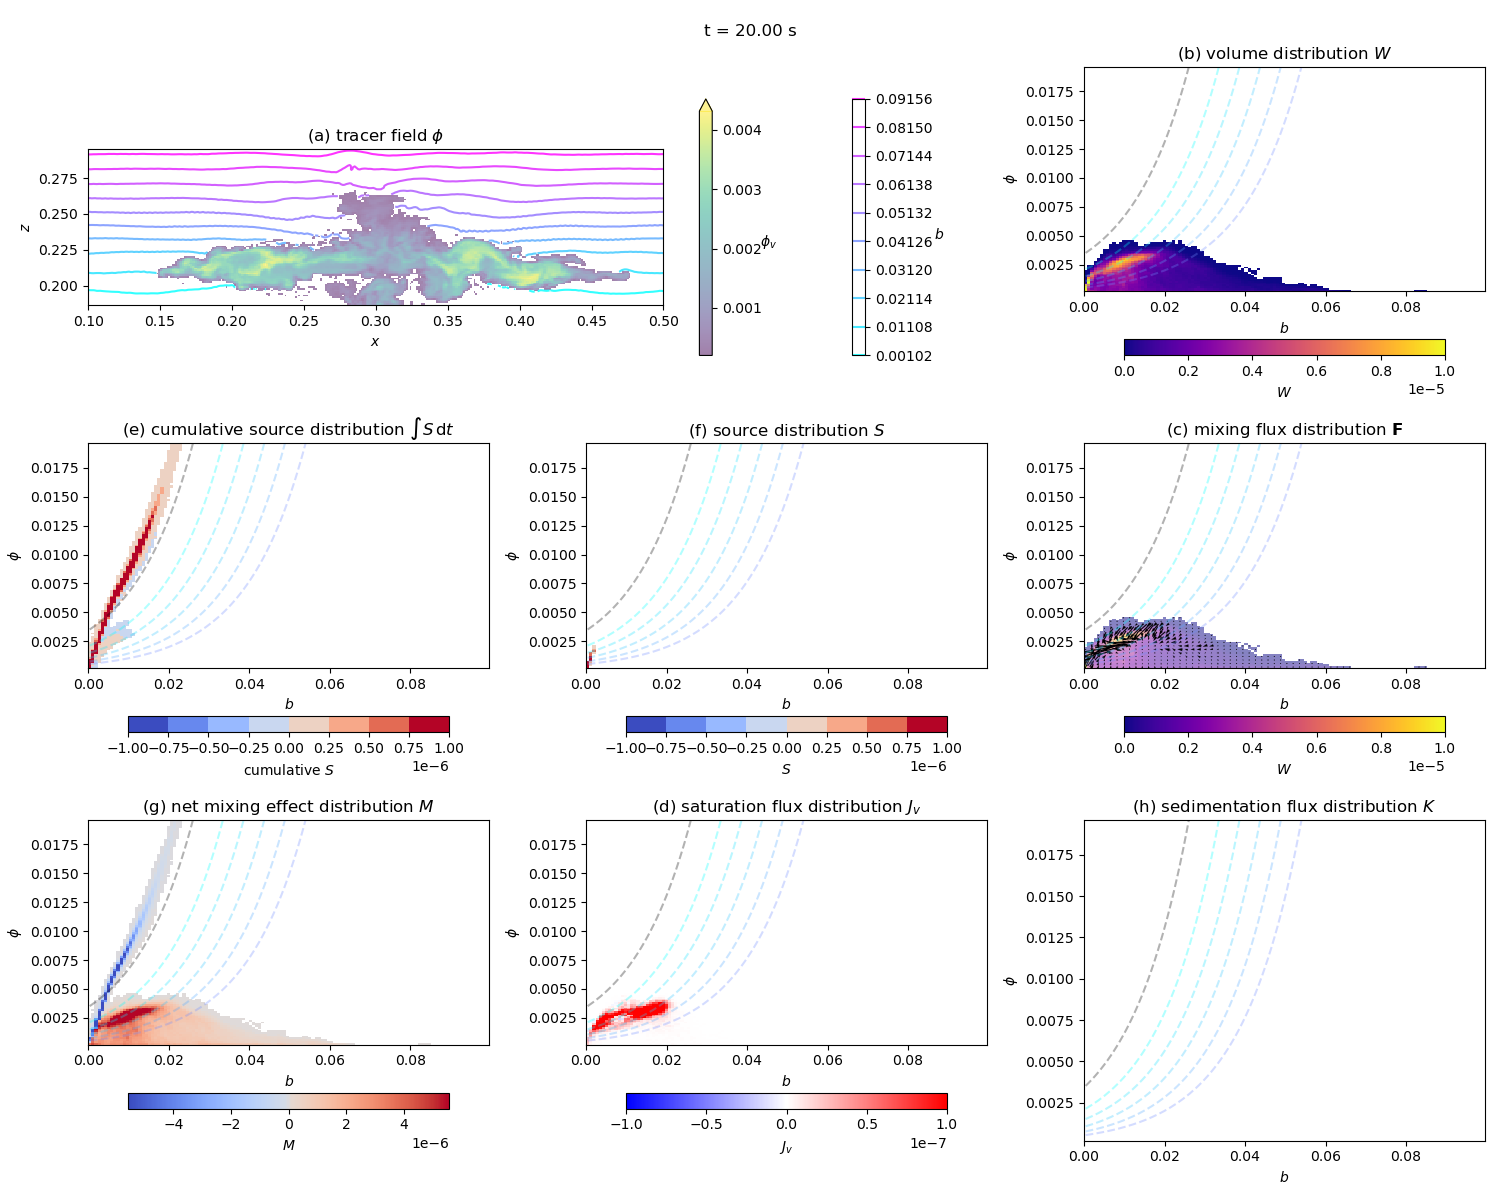

In [14]:
# Plotting loop
#fig, axs = plt.subplots(2, 4, constrained_layout=True)#, figsize=(15, 7))
#fig = plt.figure(layout="constrained", figsize=(15, 20))
fig = plt.figure(layout="tight",figsize=(15, 12))
axs = fig.subplot_mosaic(
    [
        ["plot", "plot", "W"],
        ["Scum", "S", "F"],
        ["M", "J", "K"]
    ],
)

plots(fig, axs, -1)
decorate_cb(fig, axs, -1)

def animate(step):
    for a in list(axs.keys()):
        axs[a].clear()

    plots(fig, axs, step)
    decorate(fig, axs, step)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, bitrate=-1)

anim = animation.FuncAnimation(fig, animate, interval=250, frames=list(range(t0_idx, NSAMP)), repeat=True)
now = datetime.now()
plt.show()

Mean keys: <KeysViewHDF5 ['FTx_uu', 'PVD_bbins', 'PVD_phicbins', 'PVD_phipbins', 'PVD_phivbins', 'b_phic_F1_vol', 'b_phic_F3_vol', 'b_phic_Jc_vol', 'b_phic_K_vol', 'b_phip_F1_vol', 'b_phip_F4_vol', 'b_phiv_F1_vol', 'b_phiv_F2_vol', 'b_phiv_Jv_vol', 'cp', 'dthdz01', 'dthdz02', 'dthdz03', 'dthdz04', 'dudz', 'dvdz', 'eps_sgs1', 'eps_sgs2', 'epsilon', 'gzf', 'kappa1_net', 'kappa2_net', 'kappa3_net', 'kappa4_net', 'kappa_sgs', 'mke', 'nu_sgs', 'omega_x', 'omega_y', 'omega_z', 'pe_diss01', 'pe_diss02', 'pe_diss03', 'pe_diss04', 'shear', 'tb_source', 'tb_source_bins', 'tb_strat', 'tb_strat_bins', 'td_scatter_vol', 'thme01', 'thme02', 'thme03', 'thme04', 'thrms01', 'thrms02', 'thrms03', 'thrms04', 'thw01', 'thw01_m', 'thw02', 'thw02_m', 'thw03', 'thw03_m', 'thw04', 'thw04_m', 'time', 'u1z_x0', 'ume', 'urms', 'uu_dudx', 'uv', 'uw', 'uw_dudz', 'vme', 'vrms', 'vu_dvdx', 'vw_dvdz', 'wme', 'wrms', 'wu_dwdx', 'wv', 'ww_dwdz']>
Mean keys: <KeysViewHDF5 ['FTx_uu', 'PVD_bbins', 'PVD_phicbins', 'PVD_phi

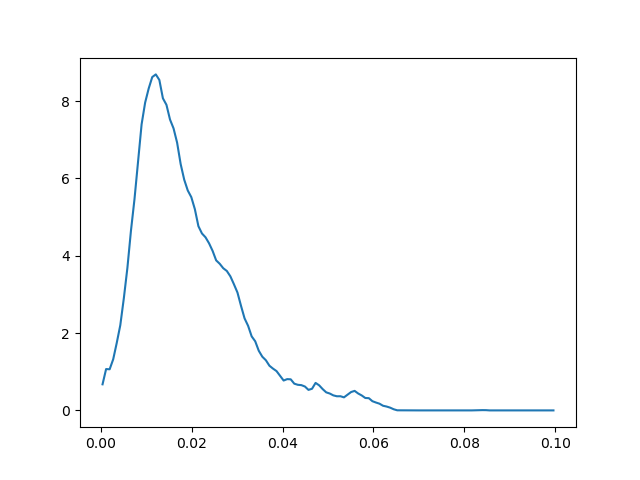

In [15]:
def hydration_profile(phibins, Wv):
    return phibins * np.nansum(Wv, axis=1)
    
h = hydration_profile(phivbins, W)/(dphiv * db * md['LX']**3)

strat_dists, mtimes = load_mean_data('tb_strat')
distbins = list(load_mean_bins('tb_strat_bins'))[0]

plt.figure()
plt.plot(bbins, h[-1])